In [1]:
import logging
import os
from itertools import product
from pathlib import Path
from typing import List, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import IPython
from IPython.display import display

os.chdir("/root/py_projects/aihiii")

from src._StandardNames import StandardNames
from src.utils.custom_log import init_logger
from src.utils.set_rcparams import set_rcparams

LOG: logging.Logger = logging.getLogger(__name__)
init_logger(log_lvl=logging.INFO)
set_rcparams()

STR: StandardNames = StandardNames()
WIDTH: float = 448.13095 / 72 - 0.2

PICTURE_DIR: Path = Path("reports") / "figures" / Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]).stem
PICTURE_DIR.mkdir(parents=True, exist_ok=True)
LOG.info("PICTURE_DIR: %s", PICTURE_DIR)

2025-01-05 11:23:14,701     INFO  MainProcess  MainThread Setting rcparams for matplotlib
2025-01-05 11:23:14,732     INFO  MainProcess  MainThread Using style src/visualization/dissertation.mplstyle
2025-01-05 11:23:14,734     INFO  MainProcess  MainThread PICTURE_DIR: reports/figures/virthuman_hiii_intercorrelation


In [2]:
REL_COLS: Dict[str, str] = {
    "Head_HIC15": "1",
    "Head_HIC36": "1",
    "Head_a3ms": "g",
    "Neck_Nij": "1",
    "Neck_Fz_Max_Compression": "kN",
    "Neck_Fz_Max_Tension": "kN",
    "Neck_My_Max": "Nm",
    "Neck_Fx_Shear_Max": "kN",
    "Chest_Deflection": "mm",
    "Chest_a3ms": "g",
    "Femur_Fz_Max_Compression": "kN",
    "Femur_Fz_Max_Tension": "kN",
    "Femur_Fz_Max": "kN",
    "Chest_VC": "m/s",
}

RENAMER = {
    "Chest_Deflection": "CDC",
    "Chest_VC": "CVC",
    "Chest_a3ms": "CAC$_3$",
    "Femur_Fz_Max_Compression": "FCC",
    "Head_HIC15": "HIC$_15$",
    "Head_a3ms": "HAC$_3$",
    "Neck_Fx_Shear_Max": "FSC",
    "Neck_Fz_Max_Tension": "NTC",
    "Neck_My_Extension": "NEC",
}

2025-01-05 11:23:19,132     INFO  MainProcess  MainThread maxp pruned
2025-01-05 11:23:19,143     INFO  MainProcess  MainThread cmap pruned
2025-01-05 11:23:19,147     INFO  MainProcess  MainThread kern dropped
2025-01-05 11:23:19,150     INFO  MainProcess  MainThread post pruned
2025-01-05 11:23:19,151     INFO  MainProcess  MainThread FFTM dropped
2025-01-05 11:23:19,155     INFO  MainProcess  MainThread GPOS pruned
2025-01-05 11:23:19,160     INFO  MainProcess  MainThread GSUB pruned
2025-01-05 11:23:19,170     INFO  MainProcess  MainThread glyf pruned
2025-01-05 11:23:19,172     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-05 11:23:19,173     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-05 11:23:19,173     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 7 glyphs before
2025-01-05 11:23:19,175     INFO  MainProcess  MainThread Glyph names: ['.notdef', '.null', 'five', 'nonmarkingreturn', 'one', 'space', 'three']
2025-01-05 11:23

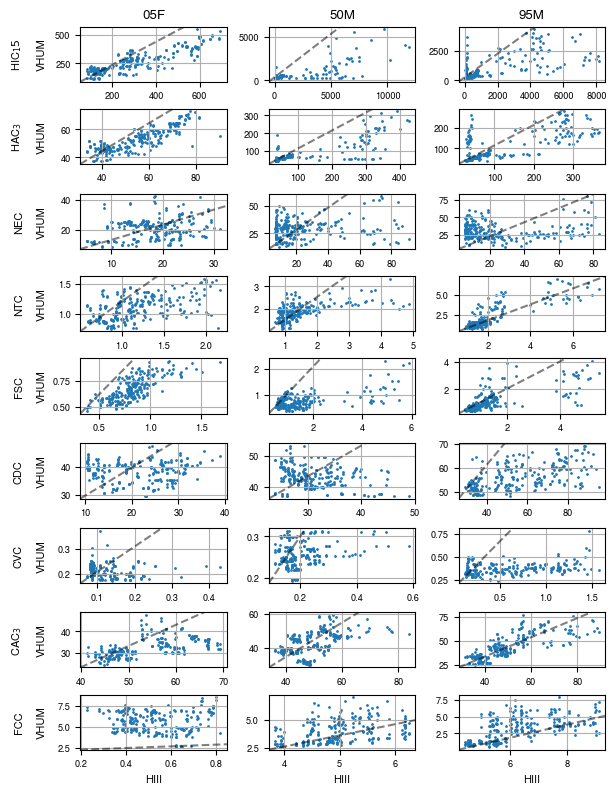

In [3]:
def make_crossplot():
    percs = (5, 50, 95)
    cols = [
        "Head_HIC15",
        "Head_a3ms",
        "Neck_My_Extension",
        "Neck_Fz_Max_Tension",
        "Neck_Fx_Shear_Max",
        "Chest_Deflection",
        "Chest_VC",
        "Chest_a3ms",
        "Femur_Fz_Max_Compression",
    ]

    fig, ax = plt.subplots(
        nrows=len(cols),
        ncols=len(percs),
        #sharey="row",
        layout="constrained",
    )

    for j, perc_ in enumerate(percs):
        dbs = {}
        for dummy, perc in [("HIII", perc_), ("VHUM", perc_ + 1)]:
            db = pd.read_parquet(
                "/root/py_projects/aihiii/data/doe/unite_hiii_virthuman/injury_criteria.parquet",
                filters=[("PERC", "==", perc)],
                columns=cols,
            ).droplevel("PERC")
            if perc ==5:
                db.drop(index=db["Head_HIC15"].nlargest(1).index, inplace=True)
            dbs[dummy] = db
            del db

        idx = dbs["HIII"].index.intersection(dbs["VHUM"].index)
        dbs["HIII"] = dbs["HIII"].loc[idx]
        dbs["VHUM"] = dbs["VHUM"].loc[idx]

        for i, col in enumerate(cols):
            ax[i, j].scatter(dbs["HIII"][col], dbs["VHUM"][col], s=1)
            if i == 0:
                ax[i, j].set_title(f"{perc_:02d}{'F' if perc_ == 5 else 'M'}")
            if j == 0:
                ax[i, j].set_ylabel(f"{RENAMER[col]}\n\nVHUM")
            if i == len(cols) - 1:
                ax[i, j].set_xlabel(f"HIII")
            ax[i, j].axline((0, 0), slope=1, color="k", transform=ax[i, j].transAxes, ls="--", alpha=0.5)
            ax[i, j].grid()
            #ax[i, j].set_xlim(mins.loc[col], maxs.loc[col])
            #ax[i, j].set_ylim(mins.loc[col], maxs.loc[col])

    fig.align_ylabels(ax)
    fig.set_figheight(1.3 * WIDTH)
    fig.set_figwidth(WIDTH)
    fig.savefig(PICTURE_DIR / "crossplot_vhum_over_hiii.pdf")


make_crossplot()